# Setting environment

In [1]:
!pip3 install -q -r requirements.txt
!virtualenv venv
!source venv/bin/activate

created virtual environment CPython3.9.6.final.0-64 in 2316ms
  creator CPython3macOsFramework(dest=/Users/sayuriiwai/Library/CloudStorage/GoogleDrive-sayuri.iwai@gmail.com/Meu Drive/0 Work/Tech/repos/ecommerce-fraud-detection/venv, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/Users/sayuriiwai/Library/Application Support/virtualenv)
    added seed packages: pip==23.1.2, setuptools==67.7.2, wheel==0.40.0
  activators BashActivator,CShellActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator


In [11]:
# Import libraries
# custom modules
from configs.custom_config import get_target_column, get_feature_columns, get_categorical_columns
from pipeline.preprocess import get_dataset, split_data, handle_missing_values, transform_categorical, scale_numerical
# external modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [12]:
main_df = get_dataset()

# EDA

In [13]:
describe_df = pd.DataFrame(columns=['attribute','null','type','count','unique_values'])

for column in main_df.columns:
    unique_values = main_df[column].unique()
    new_row = pd.Series({'attribute': column, 
                         'null': f'{round(main_df[column].isna().sum()/len(main_df),4)} %', 
                         'type': main_df[column].dtype,
                         'count': len(unique_values), 
                         'unique_values': unique_values})
    describe_df.loc[len(describe_df)] = new_row

describe_df

,attribute,null,type,count,unique_values
0,a,0.0 %,int64,4,"[4, 2, 1, 3]"
1,b,0.0866 %,float64,7673,"[0.7685, 0.755, 0.7455, 0.7631, 0.7315, 0.7359..."
2,c,0.0866 %,float64,135091,"[94436.24, 9258.5, 242549.09, 18923.9, 5728.68..."
3,d,0.0024 %,float64,52,"[20.0, 1.0, 3.0, 50.0, 15.0, 2.0, 6.0, 39.0, 1..."
4,e,0.0 %,float64,43208,"[0.4448275862068965, 0.0, 0.4823848238482384, ..."
5,f,0.0001 %,float64,1339,"[1.0, 33.0, 19.0, 18.0, 47.0, 0.0, 15.0, 41.0,..."
6,g,0.0013 %,object,52,"[BR, AR, UY, US, GB, nan, SE, FR, MX, RU, CL, ..."
7,h,0.0 %,int64,59,"[5, 0, 23, 2, 1, 11, 3, 24, 8, 17, 9, 7, 15, 2..."
8,i,0.0 %,object,127804,[Máquininha Corta Barba Cabelo Peito Perna Pel...
9,j,0.0 %,object,8324,"[cat_8d714cd, cat_64b574b, cat_e9110c5, cat_d0..."


variables b,c,d,f,g,l,m,o have null values.

b,c

d,m

f,l

g - object

o - object

The dataset on maind_df consists of 16 features (from which 14 are anonymized), the score from the last model and the target variable (fraude). There are some null values which will be dropped or have imputated values, categorical features that need to be encoded and numerical features that may be scaled.

In [14]:
fraude_unique = main_df['fraude'].unique()
df_fraude = pd.DataFrame(columns=['label','n','percentage'])
for label in fraude_unique:
    n = main_df['fraude'].value_counts()[label]
    new_row = pd.Series({'label': label,
                         'n': n,
                         'percentage': f'{round(n/len(main_df)*100,4)} %'})
    df_fraude.loc[len(df_fraude)] = new_row
df_fraude

,label,n,percentage
0,0,142500,95.0 %
1,1,7500,5.0 %


The dataset is imbalanced, which is a typical in fraud detection datasets. The fraudulent events represent the minority of the dataset, only 5 %, and demands the downsampling of the dataset

In [15]:
grouped = main_df.groupby('fraude')
null_counts = grouped.apply(lambda x: x.isnull().sum())

print(null_counts)

        a      b      c    d  e   f    g  h  i  j  k   l    m  n       o  p   
fraude                                                                        
0       0  12155  12155  336  0  11  179  0  0  0  0  11  336  0  106620  0  \
1       0    829    829   29  0   0   15  0  0  0  0   0   29  0    2237  0   

        fecha  monto  score  fraude  
fraude                               
0           0      0      0       0  
1           0      0      0       0  


In [16]:
main_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
a,150000.0,3.705407,0.753206,1.000000,4.000000,4.000000,4.000000,4.000000e+00
b,137016.0,0.728115,0.132943,0.000000,0.678400,0.755500,0.806500,1.000000e+00
c,137016.0,260445.107044,846436.141626,0.160000,9679.915000,43711.655000,145443.627500,1.387874e+07
d,149635.0,21.677669,20.062146,0.000000,2.000000,14.000000,50.000000,5.000000e+01
e,150000.0,0.220641,2.434995,0.000000,0.000000,0.104875,0.282938,8.333333e+02
f,149989.0,51.169352,709.472904,-5.000000,1.000000,8.000000,33.000000,1.452740e+05
h,150000.0,14.193513,14.161216,0.000000,3.000000,9.000000,21.000000,5.800000e+01
k,150000.0,0.497532,0.288348,0.000004,0.246819,0.495990,0.746508,9.999948e-01
l,149989.0,2305.409403,1712.379601,0.000000,910.000000,1937.000000,3445.000000,7.544000e+03
m,149635.0,299.969579,321.075806,0.000000,42.000000,193.000000,459.000000,2.225000e+03


In [17]:
threshold = 90
y_pred = np.where(main_df['score'] > threshold, 1, 0)
y_true = main_df['fraude']
l_th = classification_report(y_true, y_pred)
print(l_th)

              precision    recall  f1-score   support

           0       0.96      0.94      0.95    142500
           1       0.23      0.35      0.28      7500

    accuracy                           0.91    150000
   macro avg       0.60      0.65      0.62    150000
weighted avg       0.93      0.91      0.92    150000



In [18]:
threshold = 95
y_pred = np.where(main_df['score'] > threshold, 1, 0)
y_true = main_df['fraude']
h_th = classification_report(y_true, y_pred)
print(h_th)

              precision    recall  f1-score   support

           0       0.96      0.97      0.97    142500
           1       0.27      0.18      0.22      7500

    accuracy                           0.93    150000
   macro avg       0.61      0.58      0.59    150000
weighted avg       0.92      0.93      0.93    150000



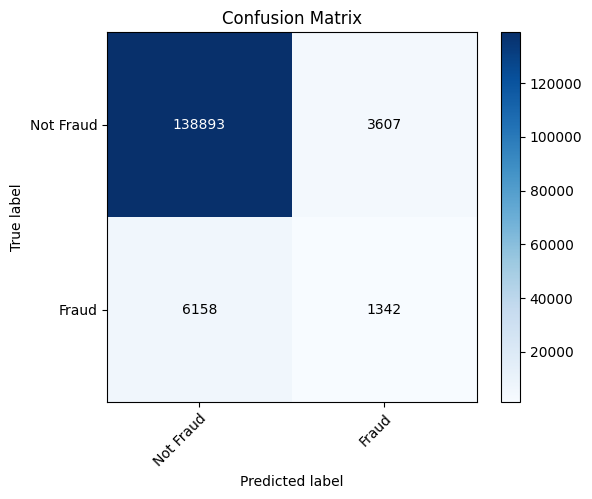

In [19]:
cm = confusion_matrix(y_true, y_pred)
labels = ['Not Fraud', 'Fraud']
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
cbar = ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=labels, yticklabels=labels,
       xlabel='Predicted label',
       ylabel='True label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
fmt = 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
ax.set_title("Confusion Matrix")
plt.show()

In [20]:
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)
tpr = tp / (tp + fn)
fnr = fn / (fn + tp)
tnr = tn / (tn + fp)
print(fpr, tpr, fnr, tnr)

0.025312280701754387 0.17893333333333333 0.8210666666666666 0.9746877192982456


In [21]:
def get_pred_at_thresholds(df_input, list_thresholds):
    '''
    function to extract prediction from model and respective chargeback or comission for each transaction
    '''
    for threshold in list_thresholds:
        df=df_input
        df[f'pred_at_{threshold}'] = df['score'].apply(lambda x: 1 if x >= threshold else 0)
        df[f'chargeback_at_{threshold}'] = df.apply(lambda row: row['monto'] if row[f'pred_at_{threshold}'] == 0 and row['fraude'] == 1 else 0, axis=1)
        df[f'comission_at_{threshold}'] = df.apply(lambda row: row['monto_comission'] if row[f'pred_at_{threshold}'] == 0 and row['fraude'] == 0 else 0, axis=1)
    return df

def plot_threshold(df):
    # extract the thresholds from the column names
    thresholds = [int(col.split('_')[-1]) for col in df.columns if 'chargeback_at' in col]

    # create the plot
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax3 = ax1.twinx()

    # plot the chargeback data on the left axis
    chargeback_data = df.filter(like='chargeback_at').sum()
    ax1.plot(thresholds, chargeback_data, 'r-', label='Chargeback')
    ax1.set_xlabel('Threshold')
    ax1.set_ylabel('Chargeback')
    ax1.tick_params('y', colors='r')

    # plot the commission data on the right axis
    commission_data = df.filter(like='comission_at').sum()
    ax2.plot(thresholds, commission_data, 'b-', label='Commission')
    ax2.set_ylabel('Commission')
    ax2.tick_params('y', colors='b')

    max_value = max(chargeback_data.max(), commission_data.max())
    ax1.set_ylim([0, max_value])
    ax2.set_ylim([0, max_value])
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.title('Chargeback and Commission vs. Threshold')

    plt.show()
    
def get_true_false_rates(cm):
    '''
    reduce false positives - high threshold - if costs (loosing comission) of false positives is high
    many more negative examples than positive examples, you may want to set a lower threshold to increase 
    the sensitivity of the model to positive examples.

    '''
    
    tn, fp, fn, tp = cm.ravel()
    fpr = fp / (fp + tn)
    tpr = tp / (tp + fn)
    fnr = fn / (fn + tp)
    tnr = tn / (tn + fp)
    print(f""" The false positive rate is {fpr}
    The true positive rate is {tpr}
    The false negative rate is {fnr}
    The true negative rate is {tnr}
    """)
    
    return(fpr, tpr, fnr, tnr)


threshold = 80
y_pred = np.where(main_df['score'] > threshold, 1, 0)
y_test = main_df['fraude']
# Calculate precision, recall, and F1-score for the model
precision_baseline, recall_baseline, f1_score_baseline, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
print(f'Metrics for current model: precision: {precision_baseline}, recall: {recall_baseline}, f1_score: {f1_score_baseline}')
plot_precision_recall_curve(y_test, y_pred)
plot_roc_curve(y_test, y_pred)
cm_baseline = plot_confusion_matrix(y_test, y_pred)
get_true_false_rates(cm_baseline)

import joblib

# new df with new model score, predictions and chargeback/comission at thresholds

model = joblib.load('model/model.pkl')
new_model = get_dataset()
new_model = new_model.drop(['m', 'p', 'score'], axis=1)
new_data = new_model.drop(['fraude'], axis=1)
missing_df = handle_missing_values(new_data)
date_df = extract_date_info(missing_df, ['fecha'])
cat_cols = ['a', 'd', 'g', 'h', 'i', 'j', 'n', 'o']
encoded_df = transform_categorical(date_df, cat_cols)
numerical_columns = ['b', 'c', 'e', 'f', 'k', 'l', 'monto']
scaled_df = scale_numerical(encoded_df,numerical_columns)
df_final = scaled_df
proba = model.predict_proba(df_final)

new_model['score'] = (proba[:, 0]*100).astype(int)
new_model['score2'] = (proba[:, 1]*100).astype(int)
new_comission_df = extract_comission(new_model)
list_thresholds = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
new_model_threshold = get_pred_at_thresholds(new_comission_df, list_thresholds)
cb_vs_c_plot = plot_threshold(new_model_threshold)

# Calculate precision, recall, and F1-score for the model
X_test, y_test = get_sets('test')
y_pred = model.predict(X_test)

precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
print(f'Metrics for random_forest: precision: {precision}, recall: {recall}, f1_score: {f1_score}')
plot_precision_recall_curve(y_test, y_pred)
plot_roc_curve(y_test, y_pred)
cm = plot_confusion_matrix(y_test, y_pred)
get_true_false_rates(cm)

print(f'Metrics for baseline model: precision: {precision_baseline}, recall: {recall_baseline}, f1_score: {f1_score_baseline}')
print(f'Metrics for random_forest: precision: {precision}, recall: {recall}, f1_score: {f1_score}')
print(cm_baseline)
print(cm)

baseline_data = [precision_baseline, recall_baseline, f1_score_baseline]
development_data = [precision, recall, f1_score]

labels = ['Precision', 'Recall', 'F1 Score']
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
baseline_bars = ax.bar(x - width/2, baseline_data, width, label='Baseline')
development_bars = ax.bar(x + width/2, development_data, width, label='Development')

ax.set_ylabel('Score')
ax.set_title('Model Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(baseline_bars)
autolabel(development_bars)
plt.show()

NameError: name 'precision_recall_fscore_support' is not defined

In [22]:
# Load the new data point
new_data_point = [2.0, 'female', None, 25]

# Impute missing values with the mode value from the training data
new_data_point[2] = mode_value

# Scale the numerical feature using the mean and standard deviation from the training data
new_data_point[0] = (new_data_point[0] - mean_value) / std_value

# One-hot encode the categorical feature using the same encoding scheme as the training data
new_data_point[1:] = one_hot_encoder.transform([new_data_point[1:]])

# Use the preprocessed new data point to make predictions
y_pred = model.predict(new_data_point)

NameError: name 'mode_value' is not defined